Important libraries

In [1]:
import os, random, math, copy, time
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.utils import make_grid
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import tensorflow as tf


**Setting rootpath**

In [2]:
from zipfile import ZipFile
zip_path = "/content/drive/MyDrive/chest X-RAys.zip"
extract_path = "/content/chest_xrays"
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


**Step 1. Ploting a Few Example Images per Class**



This helps in :-

Randomly picks one sample image from each class (NORMAL and PNEUMONIA)

Displays them side-by-side for quick visual comparison



In [6]:
import matplotlib.image as mpimg
train_dir = '/content/chest_xrays/chest_xray/train'
normal_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')


normal_imgs = os.listdir(normal_dir)
pneumonia_imgs = os.listdir(pneumonia_dir)

print(f"Number of NORMAL images: {len(normal_imgs)}")
print(f"Number of PNEUMONIA images: {len(pneumonia_imgs)}")


Number of NORMAL images: 1341
Number of PNEUMONIA images: 3875


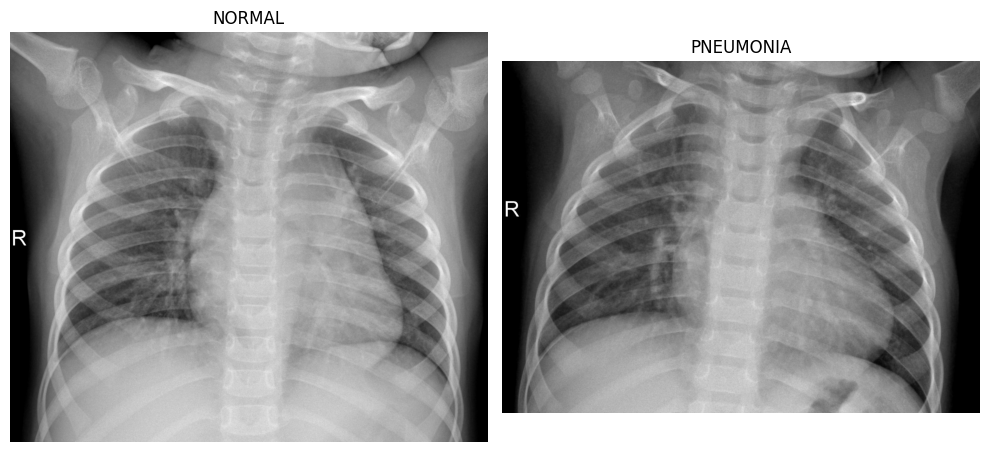

In [7]:
# Ploting random samples from each class
plt.figure(figsize=(10, 5))

for i, category in enumerate(['NORMAL', 'PNEUMONIA']):
    folder = os.path.join(train_dir, category)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = mpimg.imread(img_path)

    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()


**Step 2. Visualizing Class Distribution**

This is helpful to check if the dataset is balanced or not

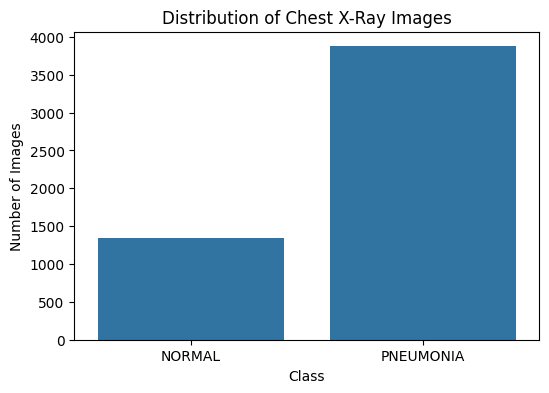

In [8]:
data_counts = {
    'NORMAL': len(os.listdir(normal_dir)),
    'PNEUMONIA': len(os.listdir(pneumonia_dir))
}

df = pd.DataFrame(list(data_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(6,4))
sns.barplot(x='Class', y='Count', data=df)
plt.title('Distribution of Chest X-Ray Images')
plt.ylabel('Number of Images')
plt.show()


**Step 3:-Displaying a Grid of Multiple Random Images**

**This helps in getting overviwe of more sample**

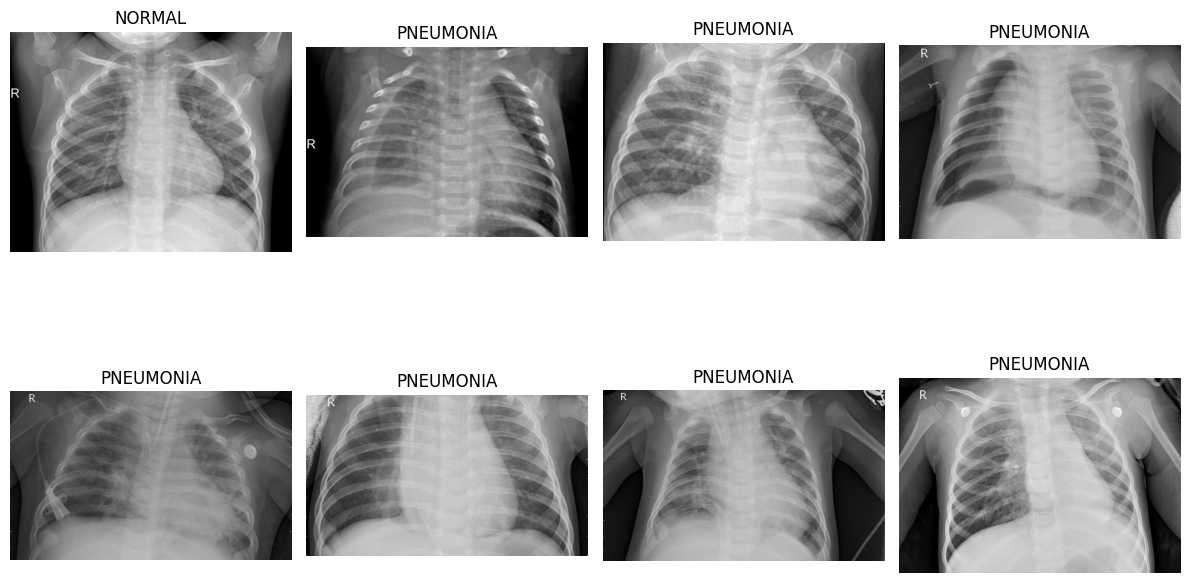

In [9]:
plt.figure(figsize=(12, 8))

for i in range(8):
    category = random.choice(['NORMAL', 'PNEUMONIA'])
    folder = os.path.join(train_dir, category)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = mpimg.imread(img_path)

    plt.subplot(2, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()


Step 4:-Doing preprocess and data augmentation

In [10]:
train_dir = '/content/chest_xrays/chest_xray/train'
val_dir = '/content/chest_xrays/chest_xray/val'
test_dir = '/content/chest_xrays/chest_xray/test'

# Apply augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [13]:
 # Rescaling for validation and test sets
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

#These objects now load, preprocess, and augment images in real-time during training.
#we’re creating a generator — not a static dataset.
#This generator does not store all images in memory. Instead, it works like a pipeline that continuously feeds your model with data.


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


**Step 5:-Visualizimg Augmented Image**
To ensure augmentation is working

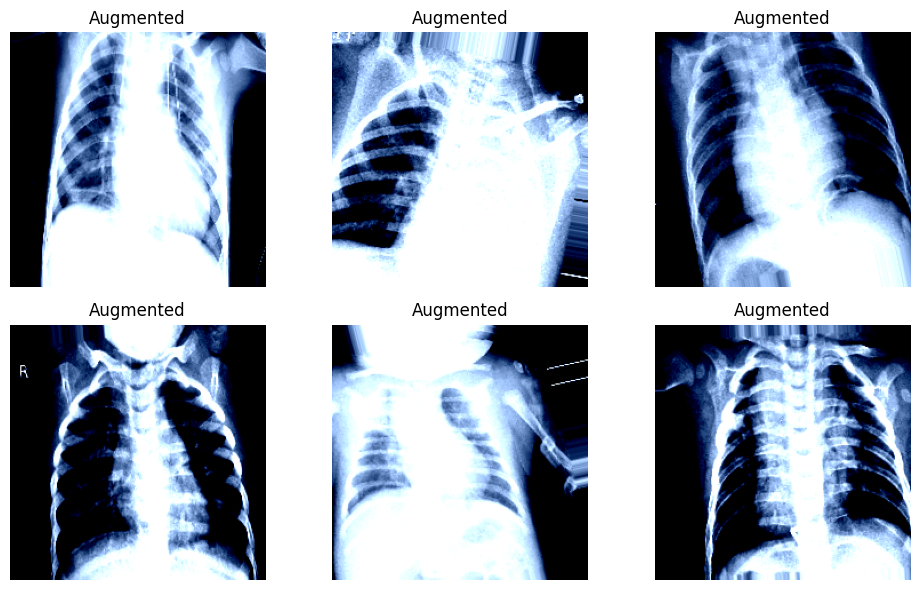

In [14]:
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title("Augmented")
    plt.axis('off')
plt.tight_layout()
plt.show()


**Step 6:-Building Model — DenseNet121**


DenseNet121 is a pre-trained CNN on ImageNet; we’ll fine-tune it for our dataset

In [15]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Step 7. Compiling the Mode**

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


**Step 8 – Quick Training on a Small Subset**

In [17]:
small_steps = 5
small_epochs = 3      # few epochs to test learning

history_small = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=small_steps,
    epochs=small_epochs,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step - accuracy: 0.3979 - loss: 1.2051 - val_accuracy: 0.5625 - val_loss: 0.7995
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - accuracy: 0.7381 - loss: 0.7300 - val_accuracy: 0.5000 - val_loss: 1.2575
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.7850 - loss: 0.8041 - val_accuracy: 0.5000 - val_loss: 1.2048


**Step:-9 ploting the learning trend after small trainnig**

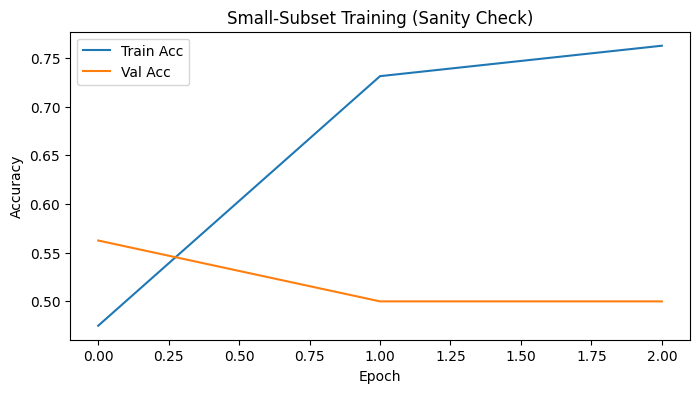

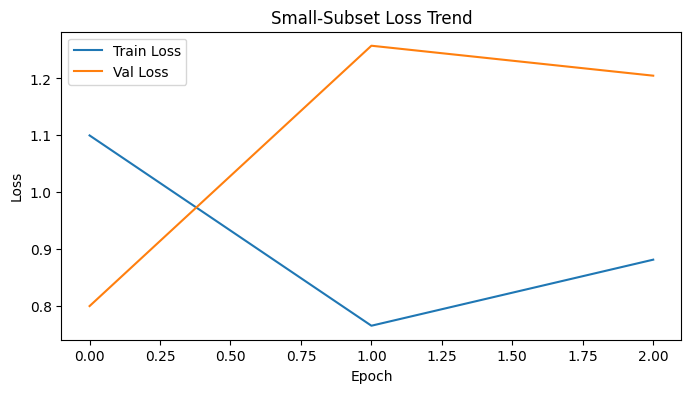

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history_small.history['accuracy'], label='Train Acc')
plt.plot(history_small.history['val_accuracy'], label='Val Acc')
plt.title('Small-Subset Training (Sanity Check)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_small.history['loss'], label='Train Loss')
plt.plot(history_small.history['val_loss'], label='Val Loss')
plt.title('Small-Subset Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Conclusion: I am Ready to Move On — With Fine-Tuning

My training behaves exactly as expected for this stage:

The model trains good

Validation flat (expected when base layers are frozen)

No NaNs or shape errors (pipeline works )

So yes — Now I am ready ready to move to the next step (training on full data).

